In [1]:
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation 
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler 
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.regularizers import l2 
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Model 

#data download link: https://www.kaggle.com/datasets/kingabzpro/magnet-nasa/download?datasetVersionNumber=1 

In [2]:
DATA_PATH = Path (r"C:\Users\Deep\Downloads\auoraNeuralNet\archive")

In [3]:
dst = pd.read_csv(DATA_PATH / "dst_labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

In [4]:
sunspots = pd.read_csv(DATA_PATH / "sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

In [5]:
solar_wind = pd.read_csv(DATA_PATH / "solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

In [52]:
print("Dst shape: ", dst.shape)
dst.head();

Dst shape:  (139872, 1)


In [104]:
dst.groupby("period").describe();

In [129]:
print("Solar wind shape: ", solar_wind.shape)
solar_wind.head()

Solar wind shape:  (8392320, 15)


bx_gse  by_gse  bz_gse  theta_gse  phi_gse  bx_gsm  \
period  timedelta                                                             
train_a 0 days 00:00:00   -5.55    3.00    1.25      11.09   153.37   -5.55   
        0 days 00:01:00   -5.58    3.16    1.17      10.10   151.91   -5.58   
        0 days 00:02:00   -5.15    3.66    0.85       7.87   146.04   -5.15   
        0 days 00:03:00   -5.20    3.68    0.68       6.17   146.17   -5.20   
        0 days 00:04:00   -5.12    3.68    0.49       4.62   145.72   -5.12   

                         by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  density  \
period  timedelta                                                            
train_a 0 days 00:00:00    3.00    1.25      11.09   153.37  6.80     1.53   
        0 days 00:01:00    3.16    1.17      10.10   151.91  6.83     1.69   
        0 days 00:02:00    3.66    0.85       7.87   146.04  6.77     1.97   
        0 days 00:03:00    3.68    0.68       6.17   146.17  6.74     1.97   
        0 days 00:04:00    3.68    0.49       4.62   145.72  6.65     1.77   

                          speed  temperature source  
period  timedelta                                    
train_a 0 days 00:00:00  383.92     110237.0     ac  
        0 days 00:01:00  381.79     123825.0     ac  
        0 days 00:02:00  389.11      82548.0     ac  
        0 days 00:03:00  389.11      82548.0     ac  
        0 days 00:04:00  384.26      94269.0     ac

In [106]:
print("Sunspot shape: ", sunspots.shape)
sunspots.head();

Sunspot shape:  (192, 1)


In [108]:
sunspots.groupby("period").describe();

In [111]:
solar_wind.isna().sum();

In [6]:
from numpy.random import seed
from tensorflow.random import set_seed

seed(2020)
set_seed(2021)

In [7]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
]

# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)


def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler

In [8]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head();

(139872, 15)


In [9]:
YCOLS = ["t0", "t1"]


def process_labels(dst):
    y = dst.copy()
    y["t1"] = y.groupby("period").dst.shift(-1)
    y.columns = YCOLS
    return y


labels = process_labels(dst)
labels.head();

In [10]:
data = labels.join(features)
data.head()

t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                         
train_a 0 days 00:00:00  -7 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10 -10.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00 -10  -6.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -6  -2.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  -2   3.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [11]:


def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = interim.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val

In [12]:
train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=3_000)


In [69]:
np.average(train['bt_std'])

-0.001599576308896294

In [122]:
print(train.shape)
train.head()

(112872, 17)


t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                         
train_a 0 days 00:00:00  -7 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10 -10.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00 -10  -6.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -6  -2.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  -2   3.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [123]:
print(val.shape)
val.head()

(9000, 17)


t0   t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                          
train_a 826 days 00:00:00   9  8.0  0.947600 -0.229038         -0.473006   
        826 days 01:00:00   8  8.0  0.464361  0.276422          0.316358   
        826 days 02:00:00   8  9.0  0.273709  0.197794          0.073052   
        826 days 03:00:00   9  8.0  0.078250  0.445950          0.290167   
        826 days 04:00:00   8  8.0 -0.172001  0.071668          0.336941   

                           temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                     
train_a 826 days 00:00:00        -0.372466    -1.575773   -0.882804   
        826 days 01:00:00         0.379133    -1.614668   -0.280527   
        826 days 02:00:00         0.302776    -1.130185    0.809654   
        826 days 03:00:00         0.460514    -0.943295    1.891776   
        826 days 04:00:00         0.437184    -0.771915    0.408708   

                           by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                             
train_a 826 days 00:00:00     0.097349    1.132243     1.867509   -0.274071   
        826 days 01:00:00     0.397057    0.655653     0.530847    0.238450   
        826 days 02:00:00     0.320615    0.122597    -1.297872   -0.367564   
        826 days 03:00:00    -0.062777   -0.024515    -0.681155    1.253984   
        826 days 04:00:00     0.332551   -0.049795    -0.704262    1.021870   

                           speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                             
train_a 826 days 00:00:00   -0.323757  -0.527592      0.392352    -0.296261   
        826 days 01:00:00   -0.155733   0.142157      0.022523    -0.150077   
        826 days 02:00:00   -0.072557   0.563556     -0.200011    -0.089490   
        826 days 03:00:00   -0.001116   0.127350      0.135548     0.048349   
        826 days 04:00:00    0.063829   0.143625     -0.027986    -0.066235   

                           smoothed_ssn  
period  timedelta                        
train_a 826 days 00:00:00      2.191722  
        826 days 01:00:00      2.191722  
        826 days 02:00:00      2.191722  
        826 days 03:00:00      2.191722  
        826 days 04:00:00      2.191722

In [124]:
from keras import preprocessing


data_config = {
    "timesteps": 34,
    "batch_size": 34,
}


def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset


train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

Number of train batches: 3315
Number of val batches: 261


In [127]:
from tensorflow.keras.layers import Dense, LSTM,Bidirectional,Dropout,Embedding
from tensorflow.keras.models import Sequential
model_config = {"n_epochs": 15, "n_neurons": 256, "dropout": 0.1, "stateful": False}
# define our model
def creat_model():
    model = Sequential()
    model.add(Input(shape=(data_config["timesteps"],
                                 len(XCOLS))))
    model.add(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(256,dropout=0.3), return_sequences=True,
                                         name="lstm1"))
#     model.add(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(256), return_sequences=True,dropout=0.1,
#                                          name="lstm1.5"))
    model.add(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(256), name="lstm2",))
    model.add(tf.keras.layers.Dense(units=2))

    return model


model=creat_model()
model.compile(
loss=tf.keras.losses.MeanSquaredError(),
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm1 (RNN)                 (None, 34, 256)           278528    
                                                                 
 lstm2 (RNN)                 (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 2)                 514       
                                                                 
Total params: 804354 (3.07 MB)
Trainable params: 804354 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [130]:
history = model.fit(
        train_ds,
        batch_size=data_config["batch_size"],
        epochs=model_config["n_epochs"],
        verbose=1,
        shuffle=False,
        validation_data=val_ds,
    )

Epoch 1/15

3315/3315 [==============================] - 444s 133ms/step - loss: 268.4696 - val_loss: 392.2883
Epoch 2/15
3315/3315 [==============================] - 395s 119ms/step - loss: 202.1278 - val_loss: 332.6729
Epoch 3/15
3315/3315 [==============================] - 406s 123ms/step - loss: 173.6186 - val_loss: 310.3097
Epoch 4/15
3315/3315 [==============================] - 391s 118ms/step - loss: 162.7137 - val_loss: 259.7582
Epoch 5/15
3315/3315 [==============================] - 394s 119ms/step - loss: 151.2287 - val_loss: 246.5561
Epoch 6/15
3315/3315 [==============================] - 372s 112ms/step - loss: 142.7466 - val_loss: 231.2795
Epoch 7/15
3315/3315 [==============================] - 375s 113ms/step - loss: 135.3683 - val_loss: 216.0992
Epoch 8/15
3315/3315 [==============================] - 376s 113ms/step - loss: 129.5412 - val_loss: 201.4874
Epoch 9/15
3315/3315 [==============================] - 377s 114ms/step - loss: 122.7448 - val_loss: 193.3982
Epoch 10/

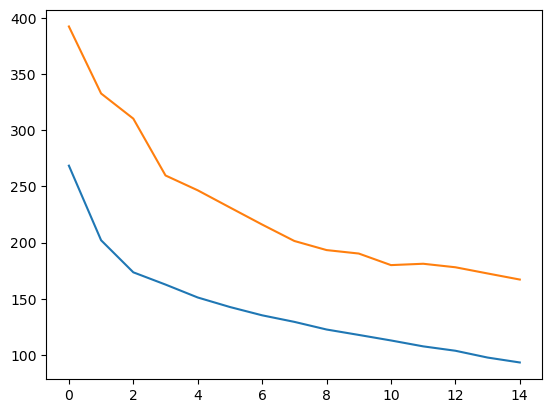

In [131]:
for name, values in history.history.items():
    plt.plot(values)

In [132]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])

In [133]:
mse = model.evaluate(test_ds)
print(f"Test RMSE: {mse**.5:.2f}")

525/525 [==============================] - 18s 34ms/step - loss: 165.2443
Test RMSE: 12.85


In [134]:
import json
import pickle
import h5py 
save_model=model.save("model.h5")

with open("scaler.pck", "wb") as f:
    pickle.dump(scaler, f)

data_config["solar_wind_subset"] = SOLAR_WIND_FEATURES
print(data_config)
with open("config.json", "w") as f:
    json.dump(data_config, f)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


{'timesteps': 34, 'batch_size': 34, 'solar_wind_subset': ['bt', 'temperature', 'bx_gse', 'by_gse', 'bz_gse', 'speed', 'density']}


In [19]:
model = keras.models.load_model("model.h5")

In [137]:

from typing import Tuple
def predict_dst(
    solar_wind_7d: pd.DataFrame,
    satellite_positions_7d: pd.DataFrame,
    latest_sunspot_number: float,
) -> Tuple[float, float]:
    """
    Take all of the data up until time t-1, and then make predictions for
    times t and t+1.
    Parameters
    ----------
    solar_wind_7d: pd.DataFrame
        The last 7 days of satellite data up until (t - 1) minutes [exclusive of t]
    satellite_positions_7d: pd.DataFrame
        The last 7 days of satellite position data up until the present time [inclusive of t]
    latest_sunspot_number: float
        The latest monthly sunspot number (SSN) to be available
    Returns
    -------
    predictions : Tuple[float, float]
        A tuple of two predictions, for (t and t + 1 hour) respectively; these should
        be between -2,000 and 500.
    """
    # Re-format data to fit into our pipeline
    sunspots = pd.DataFrame(index=solar_wind_7d.index, columns=["smoothed_ssn"])
    sunspots["smoothed_ssn"] = latest_sunspot_number
    
    # Process our features and grab last 32 (timesteps) hours
    features, s = preprocess_features(
        solar_wind_7d, sunspots, scaler=scaler, subset=SOLAR_WIND_FEATURES
    )
    model_input = features[-TIMESTEPS:][XCOLS].values.reshape(
        (1,TIMESTEPS, features.shape[1])
    )
    
    # Make a prediction
    prediction_at_t0, prediction_at_t1 = model.predict(model_input)[0]

    # Optional check for unexpected values
    if not np.isfinite(prediction_at_t0):
        prediction_at_t0 = -12
    if not np.isfinite(prediction_at_t1):
        prediction_at_t1 = -12

    return prediction_at_t0, prediction_at_t1